In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load dataset
ipos = pd.read_csv("../data/clean_bloomberg_with_sectors_macro.csv")
# get labels
ipo_labels = ipos["Underpriced"].tolist()
# get features
ipos = ipos.select_dtypes(['float64', 'float32', int])
ipo_features = ipos._get_numeric_data().columns.values.tolist()[1:-1]
# remove feature wich defines the label
ipo_features.remove('Offer To 1st Close')
# TODO remove these features from the csv
ipo_features.remove('Shares Outstanding (M).1')
ipo_features.remove('Offer Size (M).1')
print("Possible Features:", ipo_features)

Possible Features: ['Profit Margin', 'Return on Assets', 'Offer Size (M)', 'Shares Outstanding (M)', 'Offer Price', 'Market Cap at Offer (M)', 'Cash Flow per Share', 'Instit Owner (% Shares Out)', 'Instit Owner (Shares Held)', 'Real GDP Per Capita', 'OECD Leading Indicator', 'Interest Rate', 'Seasonally Adjusted Unemployment Rate', 'CPI Growth Rate', 'Industry Sector', 'Industry Group', 'Industry Subgroup']


In [16]:
# get columns for specified features
ipo_features = ipo_features[:-1]
ipo_features_data = ipos[ipo_features]
# split dataset to trianing set and test set
ipo_features_data_train, ipo_features_data_test, ipo_labels_train, ipo_labels_test = train_test_split(ipo_features_data, ipo_labels, test_size=0.3)

In [17]:
# create random forest models with various parameters
def train_and_test_model(name, n_estimators, criterion, max_depth, max_features, bootstrap) :
    accuracy = 0
    for i in range (3) :
        model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, max_features=max_features, bootstrap=bootstrap, n_jobs=-2)
        model.fit(ipo_features_data_train, ipo_labels_train)
        ipo_labels_pred = model.predict(ipo_features_data_test)
        accuracy += metrics.accuracy_score(ipo_labels_test, ipo_labels_pred)
    
    return accuracy / 3, model.get_params(True)
    

# possible parameters
estimators = [x for x in range(100, 900, 100)]
criterion = ["gini", "entropy"]
max_depth = [x for x in range(4, len(ipo_features))]
max_features = ["sqrt", "log2"]
bootstrap = [True]

params = [estimators, criterion, max_depth, max_features, bootstrap]

avg_model_accuracies_df = pd.DataFrame(columns=["Model Name", "Average Accuracy", "Parameters"])

# best model 
best_accuracy = -1.0
best_model_name = ""
best_model_params = {}
# worst model 
worst_accuracy = 1.1
worst_model_name = ""
worst_model_params = {}

# train random forest models with a permutation of the given parameters
name = "random_forest_"
s = list(itertools.product(*params))
for idx in range(len(s)) :
    model_name = name + str(idx)
    n_estimators, criterion, max_depth, max_features, bootstrap = s[idx]
    # train and test model
    model_accuracy, model_params = train_and_test_model(model_name, n_estimators, criterion, max_depth, max_features, bootstrap)
    # write to df
    avg_model_accuracies_df.loc[idx] = {
        "Model Name": model_name,
        "Average Accuracy": model_accuracy,
        "Parameters": model_params
    }
    # keep track of best and worst accuracy
    if best_accuracy < model_accuracy :
        best_accuracy = model_accuracy
        best_model_name = model_name
        best_model_params = model_params
    elif worst_accuracy > model_accuracy :
        worst_accuracy = model_accuracy
        worst_model_name = model_name
        worst_model_params = model_params

In [18]:
# convert parameters cols to cols in the data frame
avg_model_accuracies_df = avg_model_accuracies_df.join(avg_model_accuracies_df["Parameters"].apply(pd.Series))
# drop the intermediary "Parameters" col
avg_model_accuracies_df = avg_model_accuracies_df.drop(columns=["Parameters"])
avg_model_accuracies_df

,Model Name,Average Accuracy,bootstrap,ccp_alpha,class_weight,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
0,random_forest_0,0.723529,True,0.0,None,gini,4,sqrt,None,None,0.0,1,2,0.0,100,-2,False,None,0,False
1,random_forest_1,0.725490,True,0.0,None,gini,4,log2,None,None,0.0,1,2,0.0,100,-2,False,None,0,False
2,random_forest_2,0.733333,True,0.0,None,gini,5,sqrt,None,None,0.0,1,2,0.0,100,-2,False,None,0,False
3,random_forest_3,0.733987,True,0.0,None,gini,5,log2,None,None,0.0,1,2,0.0,100,-2,False,None,0,False
4,random_forest_4,0.736601,True,0.0,None,gini,6,sqrt,None,None,0.0,1,2,0.0,100,-2,False,None,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,random_forest_347,0.747712,True,0.0,None,entropy,12,log2,None,None,0.0,1,2,0.0,800,-2,False,None,0,False
348,random_forest_348,0.750327,True,0.0,None,entropy,13,sqrt,None,None,0.0,1,2,0.0,800,-2,False,None,0,False
349,random_forest_349,0.749020,True,0.0,None,entropy,13,log2,None,None,0.0,1,2,0.0,800,-2,False,None,0,False
350,random_forest_350,0.748366,True,0.0,None,entropy,14,sqrt,None,None,0.0,1,2,0.0,800,-2,False,None,0,False


In [19]:
# select the one witht he best accuracy 
print("Model " + best_model_name + " had the best accuracy with a score of", best_accuracy)
print("Best model params:", best_model_params)
print()
print("Model " + worst_model_name + " had the worst accuracy with a score of", worst_accuracy)
print("Worst model params: ", worst_model_params)

Model random_forest_241 had the best accuracy with a score of 0.7555555555555555
Best model params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 600, 'n_jobs': -2, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Model random_forest_67 had the worst accuracy with a score of 0.7215686274509804
Worst model params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -2, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


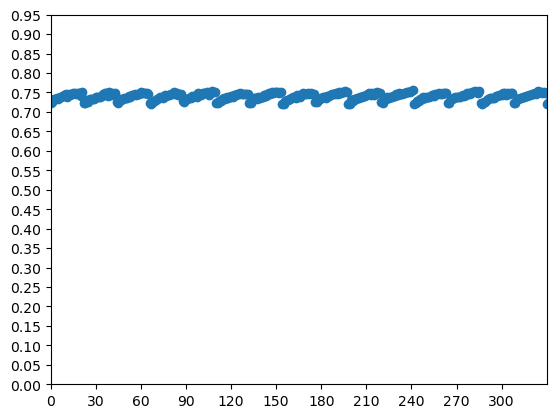

In [20]:
model_nums = list(map(lambda x: int(x[14:]), avg_model_accuracies_df["Model Name"].values)) # truncate the name of the model
values = avg_model_accuracies_df["Average Accuracy"].values
fig, ax = plt.subplots()
ax.scatter(model_nums, values)
ax.set(ylim=(0.0, 1), yticks=np.arange(0, 1, 0.05), xlim=(0, 330), xticks=np.arange(0, 330, 30))
plt.show()

We notice that there is a drop off in accuracy in about every 25 model. We further examine this below.

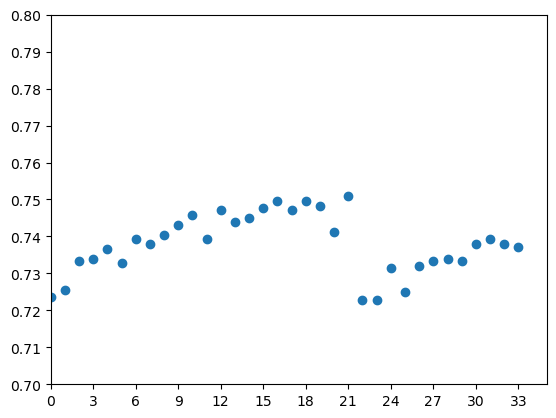

In [34]:
# look at samples from the segments of about 25
model_nums = list(map(lambda x: int(x[14:]), avg_model_accuracies_df["Model Name"].values))[:34] # truncate the name of the model
values = avg_model_accuracies_df["Average Accuracy"].values
fig, ax = plt.subplots()
ax.scatter(model_nums, values[:34])
ax.set(ylim=(0.7, 0.8), yticks=np.arange(0.70, 0.8, 0.01), xlim=(0, 35), xticks=np.arange(0, 35, 3))
plt.show()

Indeed, there is a noticable drop off of accuracy after a steady increase in accruacy. Let's see what parameters these models have

In [30]:
row0low = avg_model_accuracies_df.loc[0]
row0low_res = {
    "Average Accuracy" :row0low["Average Accuracy"],
    "criterion": row0low["criterion"],
    "max_depth": row0low["max_depth"],
    "max_features": row0low["max_features"],
    "n_estimators": row0low["n_estimators"]
    }

row21high = avg_model_accuracies_df.iloc[21]
row21high_res = {
    "Average Accuracy" :row21high["Average Accuracy"],
    "criterion": row21high["criterion"],
    "max_depth": row21high["max_depth"],
    "max_features": row21high["max_features"],
    "n_estimators": row21high["n_estimators"]
    }

row23low = avg_model_accuracies_df.iloc[23]
row23low_res = {
    "Average Accuracy" :row23low["Average Accuracy"],
    "criterion": row23low["criterion"],
    "max_depth": row23low["max_depth"],
    "max_features": row23low["max_features"],
    "n_estimators": row23low["n_estimators"]
    }

print(row0low_res)
print()
print(row21high_res)
print()
print(row23low_res)

{'Average Accuracy': 0.7235294117647059, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}

{'Average Accuracy': 0.7509803921568627, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'log2', 'n_estimators': 100}

{'Average Accuracy': 0.722875816993464, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100}


We notice that the difference between the one high performing model and the two low performing models is the `max_depth`. We further test the hypothesis that `max_depth` is the biggest contributing parameter in the model accuracy.

In [33]:
row41 = avg_model_accuracies_df.loc[41]
row41_res = {
    "Average Accuracy" :row41["Average Accuracy"],
    "criterion": row41["criterion"],
    "max_depth": row41["max_depth"],
    "max_features": row41["max_features"],
    "n_estimators": row41["n_estimators"]
    }
row42 = avg_model_accuracies_df.loc[42]
row42_res = {
    "Average Accuracy" :row42["Average Accuracy"],
    "criterion": row42["criterion"],
    "max_depth": row42["max_depth"],
    "max_features": row42["max_features"],
    "n_estimators": row42["n_estimators"]
    }
row47 = avg_model_accuracies_df.loc[47]
row47_res = {
    "Average Accuracy" :row47["Average Accuracy"],
    "criterion": row47["criterion"],
    "max_depth": row47["max_depth"],
    "max_features": row47["max_features"],
    "n_estimators": row47["n_estimators"]
    }
print(row41_res)
print()
print(row42_res)
print()
print(row47_res)

{'Average Accuracy': 0.7496732026143791, 'criterion': 'entropy', 'max_depth': 13, 'max_features': 'log2', 'n_estimators': 100}

{'Average Accuracy': 0.7450980392156863, 'criterion': 'entropy', 'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 100}

{'Average Accuracy': 0.730718954248366, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}


As expected, in the next "window" where the drop off occurs, models with a large `max_depth` perform significantly better than the model with a low `max_depth`.

Let us re-plot the models, but only looking at ones where the `max_depth` is greater than 10.

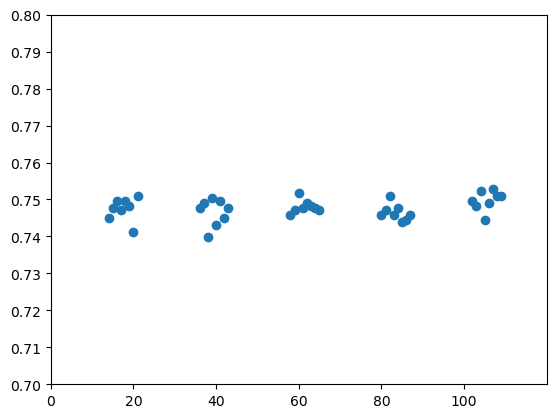

In [44]:
# select models with a large max_depth
large_max_depth_models_df = avg_model_accuracies_df.loc[avg_model_accuracies_df["max_depth"] > 10]
# plot the accuracy of the models
model_nums = list(map(lambda x: int(x[14:]), large_max_depth_models_df["Model Name"].values)) # truncate the name of the model
values = large_max_depth_models_df["Average Accuracy"].values
fig, ax = plt.subplots()
ax.scatter(model_nums, values)
ax.set(ylim=(0.7, 0.8), yticks=np.arange(0.7, 0.8, 0.01), xlim=(0, 120), xticks=np.arange(0, 120, 20))
plt.show()

The graph clearly shows, that models with `max_depth` of greater than 10 have accuracies at about `0.75`. In the next graph we highlight the discrepency between large and small `max_depth` values and their prediction accuracies. Models with `max_depth`s of greater than 10 are plotted as blue, and models with `max_depth` less than or equal to 10 are plotted as red.

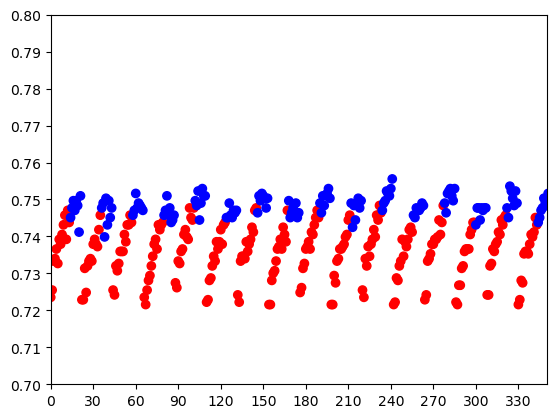

In [49]:
model_nums = list(map(lambda x: int(x[14:]), avg_model_accuracies_df["Model Name"].values)) # truncate the name of the model
values = avg_model_accuracies_df["Average Accuracy"].values

max_depths = avg_model_accuracies_df["max_depth"].values
colors = ['blue' if md > 10 else 'red' for md in max_depths]

fig, ax = plt.subplots()
ax.scatter(model_nums, values, c=colors)

ax.set(ylim=(0.7, 0.8), yticks=np.arange(0.7, 0.8, 0.01), xlim=(0, 350), xticks=np.arange(0, 350, 30))
plt.show()

Based on the graph above, we can confirm our hypothesis: models which have a large `max_depth` value perfrom the best.